# Compare NEON and PRISM data:

### Use this notebook to generate timeseries & cumulative precipitation plots

In [1]:
# Import Libraries
%matplotlib inline
from datetime import datetime
from glob import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Choose site and retrieve PRISM data

In [68]:
# Choose Year and Site (please use strings, e.g. put quotes around the year, as well)
year = '2019' # if you change this, be sure to locate the correct site index in the csv files for your site (see prism_2019_site_start_index as example)
site = 'KONZ'
username= 'tking' # CHANGE TO YOUR USERNAME

In [88]:
# Get prism data for particular year and site
pd.set_option('mode.chained_assignment', None)
prism_files_per_year = {'2018': 'PRISM_ppt_tmean_stable_4km_20180101_20181231.csv',
                        '2019': 'PRISM_ppt_tmean_stable_4km_20190101_20191231.csv',
                        '2020': 'PRISM_ppt_tmean_stable_4km_20200101_20201231.csv',
                        '2021': 'PRISM_ppt_tmean_stable_4km_20210101_20211231.csv',
                        '2022': 'PRISM_ppt_tmean_stable_4km_20220101_20220430.csv'}

# TODO: include site_start_index for other years, as well
prism_2019_site_start_index = {'BART': 11, 'HARV': 377, 'BLAN': 743, 'SCBI': 1109, 'SERC': 1474, 'DSNY': 1841,
                               'JERC': 2207, 'OSBS': 2573, 'STEI': 2939, 'TREE': 3305, 'UNDE': 3671, 'KONA': 4037,
                               'KONZ': 4403, 'UKFS': 4769, 'GRSM': 5135, 'MLBS': 5501, 'ORNL': 5867, 'DELA': 6233,
                               'LENO': 6599, 'TALL': 6965, 'DCFS': 7331, 'NOGP': 7697, 'WOOD': 8063, 'CPER': 8429,
                               'RMNP': 8795, 'STER': 9161, 'CLBJ': 9527, 'OAES': 9893, 'YELL': 10259, 'MOAB': 10625,
                               'NIWO': 10991, 'JORN': 11357, 'SRER': 11723, 'ONAQ': 12089, 'ABBY': 12455,
                               'WREF': 12821, 'SJER': 13187, 'SOAP': 13553, 'TEAK': 13919
                              }


prism_2020_site_start_index = {'BART': 11, 'HARV': 378, 'BLAN': 745, 'SCBI': 1121, 'SERC': 1479, 'DSNY': 1846,
                               'JERC': 2236, 'OSBS': 2598, 'STEI': 2964, 'TREE': 3330, 'UNDE': 3697, 'KONA': 4062,
                               'KONZ': 4428, 'UKFS': 4799, 'GRSM': 5160, 'MLBS': 5526, 'ORNL': 5892, 'DELA': 6258,
                               'LENO': 6624, 'TALL': 6990, 'DCFS': 7356, 'NOGP': 7722, 'WOOD': 8088, 'CPER': 8454,
                               'RMNP': 8820, 'STER': 9186, 'CLBJ': 9553, 'OAES': 9920, 'YELL': 10287, 'MOAB': 10654,
                               'NIWO': 11021, 'JORN': 11388, 'SRER': 11755, 'ONAQ': 12122, 'ABBY': 12489,
                               'WREF': 12856, 'SJER': 13223, 'SOAP': 13590, 'TEAK': 13957
                              }
start_index = {'2019': prism_2019_site_start_index,
               '2020': prism_2020_site_start_index}

# perform conversions and gather relevant data
prism_df = pd.read_csv(prism_files_per_year[year], sep=';')

# find relevant rows based on whether or not site is in cell
prism_data = prism_df[prism_df['PRISM Time Series Data'].str.contains(site)]

new_df = prism_data["PRISM Time Series Data"].str.split(",", expand = True)

prism_data["Precip"] = new_df[5]  # rain is 6th value in csv file, indexing starts at 0, so index #6
prism_data["Time"] = new_df[4]  # date is 5th value in csv file, indexing starts at 0, so index #4

# Perform unit conversions
prism_data['Precip'] = prism_data['Precip'].astype(float)

In [89]:
# read in NEON data

# EITHER use default data
# half_hourly_files = '/scratch/data/NEONv2/datm/{}/{}_atm_{}-*.nc'.format(site,site, year)

# OR use data from the case you ran
half_hourly_files = '/home/{}/scratch/NEON_cases/{}.PRISM.transient/run/inputdata/atm/cdeps/v2/{}/{}_atm_{}-*.nc'.format(username, site, site, site, year)

half_hourly_neon_dataset = xr.open_mfdataset(half_hourly_files, parallel=True)

In [90]:
# resample NEON data to be daily
daily_neon_prect_dataset = half_hourly_neon_dataset['PRECTmms'].resample(time='D').mean()

In [91]:
# get correct units (mm/s * (3600s/hr) * (24hr/day) = mm/day)
daily_neon_prect = daily_neon_prect_dataset[:,0,0] * 3600 * 24 

In [92]:
# gather time and precipitation data from PRISM files, and use reformat time values
prism_time_vals = prism_data['Time']
prism_precip_vals = prism_data['Precip']

prism_times=[]
for val in prism_time_vals:
    prism_times.append(datetime.strptime(val,'%Y-%m-%d'))

### Calendar year daily precipitation plot

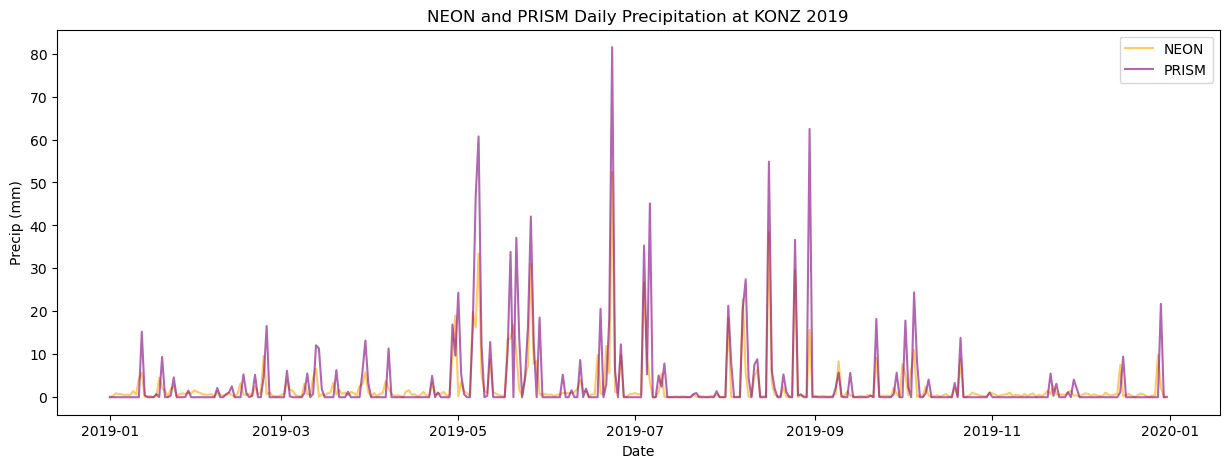

In [93]:
# Plot datasets
plt.plot(daily_neon_prect['time'], daily_neon_prect, label="NEON", color="orange", alpha=0.6)
plt.plot(prism_times,prism_precip_vals, label='PRISM', color='purple', alpha=0.6)
plt.rcParams["figure.figsize"] = (15,5)
plt.xlabel('Date')
plt.ylabel('Precip (mm)')
plt.title("NEON and PRISM Daily Precipitation at {} {}".format(site, year))
plt.legend()
plt.show()

### Calendar year cumulative precipitation plot

In [94]:
# Sum PRISM precip values over the course of the year
cumulative_prism_precip_vals=[]
for index in range(start_index[year][site], start_index[year][site]+365):
    cumulative_val = np.sum(prism_precip_vals.loc[:index])
    cumulative_prism_precip_vals.append(cumulative_val)

# NEON data is in different format
daily_neon_prect_array = daily_neon_prect.compute()
cumulative_daily_neon_prect = []
for index in range(0,365):
    cumulative_val = np.sum(daily_neon_prect_array[:index])
    cumulative_daily_neon_prect.append(cumulative_val)

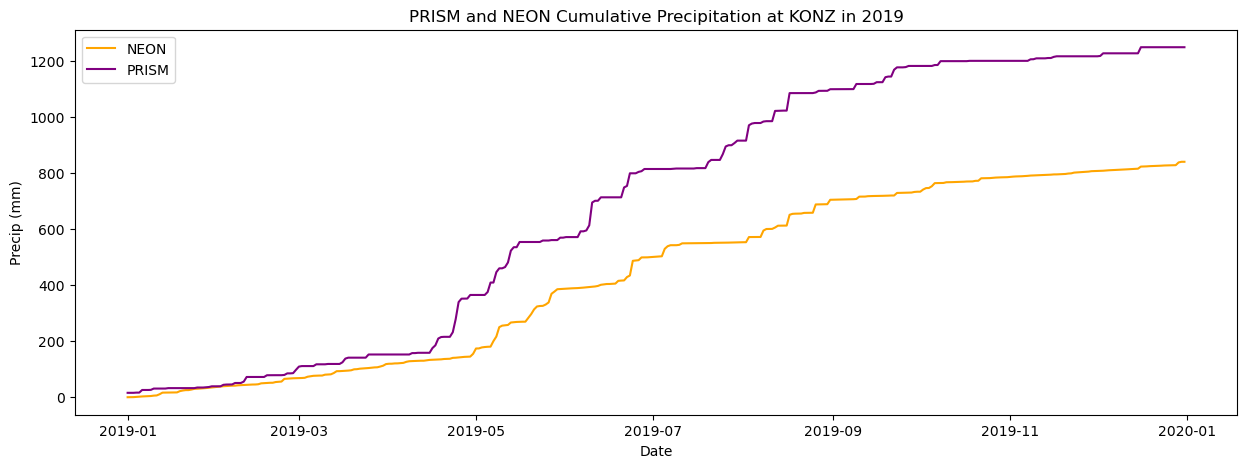

In [86]:
# Plot cumulative precipitation
plt.plot(daily_neon_prect['time'], cumulative_daily_neon_prect, label="NEON", color="orange", alpha=1)
plt.plot(prism_times, cumulative_prism_precip_vals, label='PRISM', color='purple', alpha=1)
plt.rcParams["figure.figsize"] = (15,5)
plt.xlabel('Date')
plt.ylabel('Precip (mm)')
plt.title("PRISM and NEON Cumulative Precipitation at {} in {}".format(site, year))
plt.legend()
plt.show()